Principal Component Analysis (PCA) is a method that takes several numeric variables and transforms them into a smaller number of new variables called principal components. Each principal component is a combination of the original features, and they are created in a way that the first component captures the most variation in the data, the second captures the next most, and so on. The goal is to reduce the complexity of the dataset while still keeping the major patterns.

In [7]:
import pandas as pd
clean = pd.read_csv("out/pitchfork_reviews_clean_MAO.csv")
merged = pd.read_csv("merged_data.csv")

print("CLEAN COLUMNS:\n", clean.columns.tolist(), "\n")
print("MERGED COLUMNS:\n", merged.columns.tolist())

CLEAN COLUMNS:
 ['artist', 'album', 'score', 'genre', 'label', 'reviewer', 'year', 'review_date', 'length', 'url', 'genre_clean', 'genre_list', 'genre_cleaned', 'genre_len', 'main_genre'] 

MERGED COLUMNS:
 ['artist', 'album', 'score', 'genre', 'label', 'reviewer', 'album_year', 'review_date', 'length', 'url', 'artist_id', 'followers_count', 'review_datetime', 'review_year', 'reviewer_reviews', 'review_release_difference', 'artist_reviews', 'artist_review_number']


Building the PCA

I'll use numeric columns from MERGED and bring in main_genre (and maybe genre_len) from CLEAN.

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load both datasets
clean = pd.read_csv("out/pitchfork_reviews_clean_MAO.csv")
merged = pd.read_csv("merged_data.csv")

# Adds useful columns from clean (main_genre and genre_len)
df = merged.copy()
df["main_genre"] = clean["main_genre"]
df["genre_len"] = clean["genre_len"]  # number of genres, numeric


In [9]:
# Filter useful rows
pca_df = df[df["followers_count"] > 0].copy()

# Log transform the follower count
pca_df["log_followers"] = np.log10(pca_df["followers_count"])

# Gather all numeric features for PCA
features = [
    "score",
    "log_followers",
    "length",
    "review_year",
    "review_release_difference",
    "reviewer_reviews",
    "artist_reviews",
    "genre_len"
]

X = pca_df[features].dropna()

In this project, PCA was applied to numeric features such as score, log followers, review length, review year, review-release difference, reviewer activity, artist activity, and the number of genres. Before applying PCA, all variables were standardized so that differences in scale (for example, followers being in millions and review length being in hundreds of words) do not distort the analysis.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_


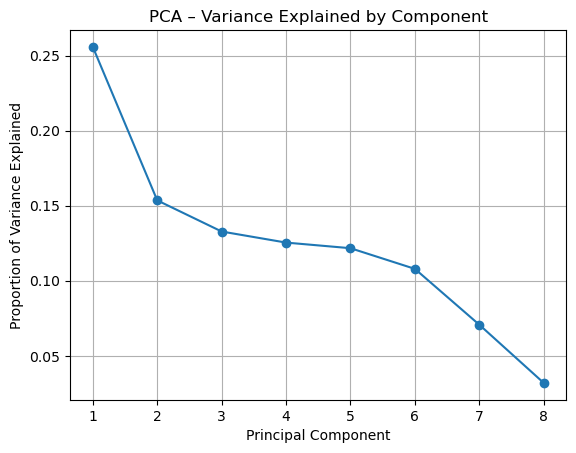

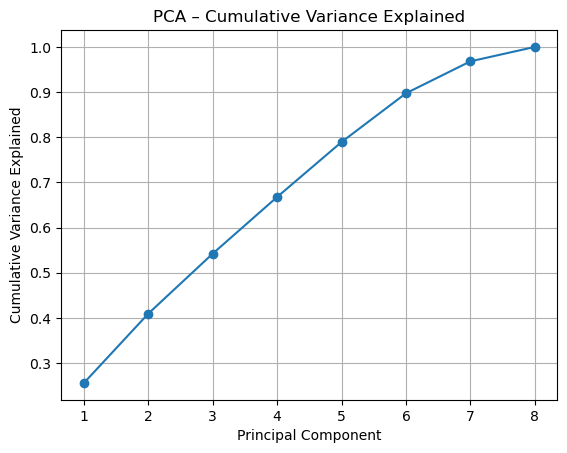

In [ ]:
# Scree Plot, Plot variance explained 

plt.figure()
plt.plot(range(1, len(explained) + 1), explained, marker="o")
plt.title("PCA - Variance Explained by Component")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(explained) + 1), explained.cumsum(), marker="o")
plt.title("PCA - Cumulative Variance Explained")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()


1. 

The variance explained plot shows that PC1 captures the largest share of variation at around 25%, while PC2 and PC3 each explain roughly 10–15%. The remaining components contribute smaller but still meaningful amounts. This indicates that the dataset does not have a single dominant direction of variation, and multiple dimensions are required to describe the structure of the numerical features.

2.

The cumulative variance plot shows that the first five principal components together explain almost 80% of the total variance. So most of the meaningful variation in the dataset can be summarized using a reduced set of components instead of all original numeric features. Using two or three components preserves a moderate amount of information, while using five captures a substantial majority.


The variance explained plots show how much of the total variability each component captures. PC1 explains around 25% of the variance, and the next few components explain between 10% and 15% each. This indicates that no single feature or dimension is dominating the behavior of the data. Instead, multiple factors contribute meaningful information. By the time we reach five components, nearly 80% of the total variation in the dataset is retained. This means that the original eight numeric features can effectively be reduced to five components without losing too much information.

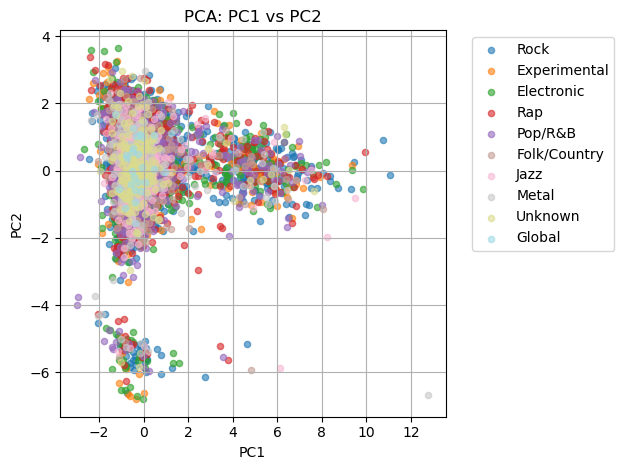

In [13]:
PC1 = X_pca[:, 0]
PC2 = X_pca[:, 1]

genres = pca_df.loc[X.index, "main_genre"]

# Gets unique genre list + color map
unique_genres = genres.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_genres)))

plt.figure()
for genre, color in zip(unique_genres, colors):
    mask = (genres == genre)
    plt.scatter(PC1[mask], PC2[mask], label=genre, alpha=0.6, s=20, color=color)

plt.title("PCA: PC1 vs PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


The PC1 vs PC2 scatter plot shows significant overlap between genres which means genre does not form any notable clusters in the space defined by the first two principal components. Albums from different genres share similar patterns in popularity, review length, review timing, and other numeric features, which suggests that genre alone is not a strong differentiator in this reduced dimensional representation.


This shows that the numeric features used in PCA do not cluster albums cleanly by genre. In other words, review length, timing, popularity, and reviewer/artist history vary within genres just as much as across genres. This supports earlier conclusions that genre is not strongly tied to these numerical characteristics.


In [14]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(features))],
    index=features
)

loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
score,0.435540,-0.350053,0.142137,0.089132,0.168620,-0.409136,0.674300,-0.095469
log_followers,0.197806,0.696547,-0.228964,-0.021697,-0.062460,0.365577,0.493482,-0.204272
length,0.629759,0.021938,-0.065173,-0.025868,-0.016534,0.190639,-0.154621,0.733131
review_year,0.066099,-0.013059,0.781451,-0.164307,0.346315,0.475151,-0.006324,-0.109796
review_release_difference,0.607293,-0.024650,-0.076788,-0.003864,-0.090597,-0.043781,-0.480018,-0.619786
reviewer_reviews,-0.035881,-0.321388,-0.468180,0.343619,0.612980,0.418663,-0.001614,-0.084439
artist_reviews,-0.009708,-0.536349,-0.131719,-0.302189,-0.557545,0.486908,0.217474,-0.091304
genre_len,0.005025,-0.008062,0.264613,0.868626,-0.390705,0.150249,0.011495,0.004641


The loadings show how each original variable contributes to each principal component. PC1 is mainly influenced by review length and review release difference, meaning it reflects patterns in how long and how delayed reviews tend to be. PC2 is dominated by log followers and negatively by artist review counts, which represents a popularity dimension. PC3 is strongly associated with review year, separating older and newer releases. The presence of multiple moderately strong loadings confirms that several factors jointly shape the PCA structure.




Overall, PCA reveals that the structure of the data is shaped by several different factors: popularity (followers), review behavior (length and delay), time (review year), and reviewer or artist activity. No single factor dominates, and genre is not a major separator in numeric space. PCA therefore helps confirm the complexity of the dataset and provides a lower dimensional representation that summarizes the main axes of variation while preserving most of the important information.
